In [1]:
# Install Pytorch-Lightning
!pip install pytorch_lightning

     |████████████████████████████████| 102kB 5.4MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.6.0-cp36-none-any.whl size=116150 sha256=ebfbf392180d959c352a756bb46c5c741f34d2b617edbcfc6ff55f694ba97a4e
  Stored in directory: /root/.cache/pip/wheels/53/08/72/257c395e632f8e4d68770e3935e1ba489e8a7cc82b2fd8d241
Successfully built pytorch-lightning


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
torch.__version__

'1.3.0'

---
## Data Confirming

In [4]:
# Check Current Directory
os.listdir('../input/dogs-vs-cats-redux-kernels-edition')

['test.zip', 'train.zip', 'sample_submission.csv']

In [5]:
# Make Directory for extracting from Zip
os.makedirs('../data', exist_ok=True)

In [6]:
# Train_dir, Test_dir
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [7]:
# Extract All Data From Zip to "../data" Directory
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [8]:
# Check File Name
os.listdir(train_dir)[:5]

['dog.890.jpg', 'dog.1178.jpg', 'dog.7845.jpg', 'dog.4632.jpg', 'cat.3660.jpg']

In [9]:
# FilePath List
train_img_path = glob.glob(os.path.join(train_dir, '*.jpg'))
test_img_path = glob.glob(os.path.join(test_dir, '*.jpg'))

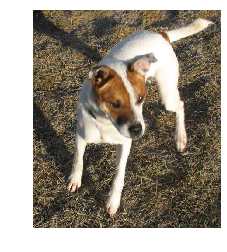

In [10]:
img = Image.open(train_img_path[0])
plt.imshow(img)
plt.axis('off')
plt.show()

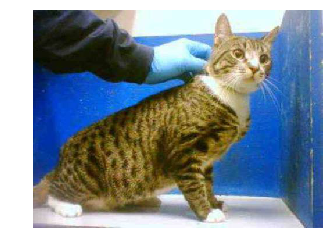

In [11]:
img = Image.open(test_img_path[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
# Label is contained in filepath
train_img_path[:5]

['../data/train/dog.890.jpg',
 '../data/train/dog.1178.jpg',
 '../data/train/dog.7845.jpg',
 '../data/train/dog.4632.jpg',
 '../data/train/cat.3660.jpg']

In [13]:
# Image_Id is contained in filepath
test_img_path[:5]

['../data/test/10435.jpg',
 '../data/test/6790.jpg',
 '../data/test/4644.jpg',
 '../data/test/1835.jpg',
 '../data/test/1102.jpg']

In [14]:
# Get Label
print(train_img_path[0].split('/')[-1].split('.')[0])
# Get Image_Id
print(int(test_img_path[0].split('/')[-1].split('.')[0]))

dog
10435


In [15]:
# Number of Train Image
print('Train Data Num: ', len(train_img_path))
# Number of Test Image
print('Test Data Num: ', len(test_img_path))

Train Data Num:  25000
Test Data Num:  12500


---
## Data Augmentation

In [16]:
# Data Augmentation
class ImageTransform():
    def __init__(self, img_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

---
## Dataset

In [17]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        # Transformimg Image
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

---
## Pytorch Lightning

In [18]:
class DogCatModelSystem(pl.LightningModule):
    
    def __init__(self, img_path, criterion, batch_size, img_size):
        super(DogCatModelSystem, self).__init__()
        self.criterion = criterion
        self.batch_size = batch_size
        self.img_size = img_size
        
        # Load Data  ###############################################################################
        self.img_path = img_path
        # Split Train/Val Data
        self.train_img_path, self.val_img_path = train_test_split(self.img_path, test_size=0.1)
        # Dataset
        self.train_dataset = DogvsCatDataset(self.train_img_path, 
                                             ImageTransform(self.img_size), 
                                             phase='train')
        
        self.val_dataset = DogvsCatDataset(self.val_img_path, 
                                           ImageTransform(self.img_size), 
                                           phase='val')
        
        # Model  ###############################################################################
        # Pretrained VGG16
        use_pretrained = True
        self.net = models.vgg16(pretrained=use_pretrained)
        # Change Output Size of Last FC Layer (4096 -> 1)
        self.net.classifier[6] = nn.Linear(in_features=self.net.classifier[6].in_features, out_features=2)
        # Specify The Layers for updating
        params_to_update = []
        update_params_name = ['classifier.6.weight', 'classifier.6.bias']

        for name, param in self.net.named_parameters():
            if name in update_params_name:
                param.requires_grad = True
                params_to_update.append(param)
            else:
                param.requires_grad = False
        # Set Optimizer
        self.optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
    
    # Method  ###############################################################################
    # Set Train Dataloader
    @pl.data_loader
    def train_dataloader(self):
        '''
        REQUIRED
        Set Train Dataloader
        '''
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
    
    # Set Valid Dataloader
    @pl.data_loader
    def val_dataloader(self):
        '''
        REQUIRED
        Set Validation Dataloader
        '''
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=4, pin_memory=True)
    
    def forward(self, x):
        return self.net(x)
    
    # Set optimizer, and schedular
    def configure_optimizers(self):
        # [optimizer], [schedular]
        return [self.optimizer], []
    
    # Train Loop
    def training_step(self, batch, batch_idx):
        '''
        REQUIRED
        batch: Output from DataLoader
        batch_idx: Index of Batch
        '''
        
        # Output from Dataloader
        imgs, labels = batch
        
        # Prediction
        preds = self.forward(imgs)
        # Calc Loss
        loss = self.criterion(preds, labels)
        
        # Calc Correct
        _, preds = torch.max(preds, 1)
        correct = torch.sum(preds == labels).float() / preds.size(0)
        
        logs = {'train_loss': loss, 'train_correct': correct}
        
        return {'loss': loss, 'log': logs, 'progress_bar': logs}
    
    # Validation Loop
    def validation_step(self, batch, batch_idx):
        '''
        OPTIONAL
        SAME AS "trainning_step"
        '''
        # Output from Dataloader
        imgs, labels = batch
        
        # Prediction
        preds = self.forward(imgs)
        # Calc Loss
        loss = self.criterion(preds, labels)
        
        # Calc Correct
        _, preds = torch.max(preds, 1)
        correct = torch.sum(preds == labels).float() / preds.size(0)
        
        logs = {'val_loss': loss, 'val_correct': correct}
        
        return {'val_loss': loss, 'val_correct': correct, 'log': logs, 'progress_bar': logs}
    
    # Aggegate Validation Result
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_correct = torch.stack([x['val_correct'] for x in outputs]).mean()
        logs = {'avg_val_loss': avg_loss, 'avg_val_correct': avg_correct}
        torch.cuda.empty_cache()

        return {'avg_val_loss': avg_loss, 'log': logs}

In [19]:
# Config  ################################################
criterion = nn.CrossEntropyLoss()
batch_size = 32
img_size = 224
epoch = 2

# Set LightningSystem  ################################################
model = DogCatModelSystem(train_img_path, criterion, batch_size, img_size)

# Callbacks  ################################################
# Save Model
# checkpoint_callback = ModelCheckpoint(filepath='SAVE_FILE_PATH', monitor='val_loss',
#                                       save_best_only=True, mode='min', save_weights_only=True)
# EarlyStopping
# earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=2)

# Trainer  ################################################
trainer = Trainer(
    max_nb_epochs=epoch,                        # Set Num Epoch
#     default_save_path=output_path,            # Path for save lightning_logs
#     checkpoint_callback=checkpoint_callback,  # Set Checkpoint-Callback
#     early_stop_callback=earlystopping,        # Set EarlyStopping-Callback
#     gpus=[0]                                  # GPU
)

# Start Training!!  ################################################
trainer.fit(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.4MB/s]
                                                                         

Epoch 1:   0%|          | 0/783 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 783/783 [1:43:22<00:00,  7.92s/batch, batch_idx=703, loss=0.043, train_correct=1, train_loss=0.00864, v_num=0]


/opt/conda/lib/python3.6/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:314: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:144: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,train_loss,train_correct,avg_val_loss,avg_val_correct
  RuntimeWarning)


1

---
## Prediction

In [20]:
def prediction(test_img_path, model, img_size, device):
    id_list = []
    pred_list = []

    with torch.no_grad():
        for path in tqdm(test_img_path):
            
            # Preprocessing  #########################################
            img = Image.open(path)
            _id = int(path.split('/')[-1].split('.')[0])

            transform = ImageTransform(img_size)
            img = transform(img, phase='test')
            img = img.unsqueeze(0)
            img = img.to(device)
            
            # Predict  ##############################################
            model.eval()

            outputs = model(img)
            preds = F.softmax(outputs, dim=1)[:, 1].tolist()

            id_list.append(_id)
            pred_list.append(preds[0])

    # Result DataFrame
    res = pd.DataFrame({
        'id': id_list,
        'label': pred_list
    })
    
    # Submit
    res.sort_values(by='id', inplace=True)
    res.reset_index(drop=True, inplace=True)
    res.to_csv('submission.csv', index=False)
    
    return res

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
res = prediction(test_img_path, model, img_size, device)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


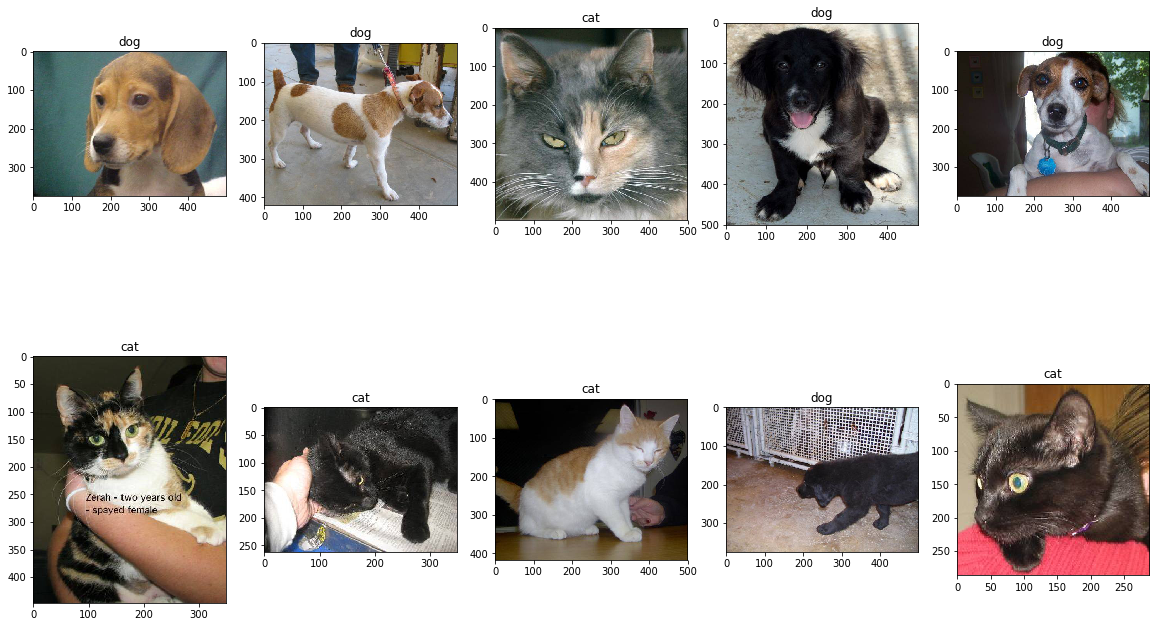

In [22]:
# Visualize Prediction
id_list = []
class_ = {0: 'cat', 1: 'dog'}
fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    # Select Image
    i = random.choice(res['id'].values)
    
    label = res.loc[res['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)